<a href="https://colab.research.google.com/github/Ronak1998/Model_outputs/blob/master/House_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# univariate cnn lstm example
import tensorflow.compat.v1 as tf
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras.utils

Using TensorFlow backend.


In [0]:
import pandas as pd
import time
from datetime import date, time, timedelta
import numpy as np
from numpy import asarray
from numpy import save
from sklearn import preprocessing
from google.colab import drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
file = r'/gdrive/My Drive/Colab Notebooks/NILM/REDDhouse1_lowf_VA.csv'
df = pd.read_csv(file)
print(df)

        TimeStamp    MAIN   OVEN   REFG  ...   BATH   HEAT   STOV   DIFF
0       1303132933    340      0      6  ...      1      0      0     79
1       1303132936    342      0      6  ...      1      0      0     81
2       1303132940    341      0      6  ...      1      0      0     79
3       1303132943    341      0      6  ...      1      0      0     79
4       1303132946    340      0      6  ...      1      0      0     79
...            ...    ...    ...    ...  ...    ...    ...    ...    ...
406743  1306266980    273      0    186  ...      1      0      0     31
406744  1306266983    273      0    187  ...      1      0      0     33
406745  1306266987    273      0    190  ...      1      0      0     30
406746  1306266990    273      0    189  ...      1      0      0     31
406747  1306266994    273      0    186  ...      1      0      0     32

[406748 rows x 13 columns]


In [0]:
array = df.to_numpy()
dataset = pd.DataFrame({'timestamp': array[:,0], 'Main': array[:,1], 'Oven': array[:,2], 'Refg': array[:,3], 'Dish': array[:,4], 'Kitch': array[:,5], 'Lite': array[:,6], 'Dryr': array[:,7], 'Micr': array[:,8], 'Bath': array[:,9], 'Heat': array[:,10], 'Stov': array[:,11],'Diff': array[:,12]})
dataset = dataset.set_index(['timestamp'])
dataset.index = pd.to_datetime(dataset.index, unit='s')
dataset = dataset.resample('1min').mean()
dataset = dataset.dropna()
dataset.describe()

,Main,Oven,Refg,Dish,Kitch,Lite,Dryr,Micr,Bath,Heat,Stov,Diff
count,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000
mean,382.908284,13.731572,54.990180,25.396969,57.172662,74.117537,35.850292,22.183838,7.003494,0.127257,0.114912,92.219572
std,747.425265,211.077353,85.166772,149.214637,87.244082,64.251739,288.437464,147.068870,91.989994,0.946020,0.799245,334.331542
min,90.666667,0.000000,0.500000,0.000000,40.266667,0.333333,0.000000,1.687500,0.000000,0.000000,0.000000,0.800000
25%,136.875000,0.000000,6.312500,0.000000,43.125000,3.200000,0.000000,4.000000,1.000000,0.000000,0.000000,32.687500
50%,175.812500,0.000000,6.750000,0.000000,44.000000,81.500000,0.000000,4.000000,1.000000,0.000000,0.000000,37.375000
75%,349.312500,0.000000,101.750000,0.000000,46.000000,84.400000,0.000000,4.000000,1.000000,0.000000,0.000000,54.000000
max,11556.250000,4156.625000,437.800000,1153.066667,2725.600000,418.666667,3251.812500,1771.250000,1664.187500,19.600000,16.333333,3378.937500


In [0]:
def LSTM_pre_processing(dataset, appliance, starting, ending, value1, value2):
  for i in range(starting, ending):
    if value1 == 0:
      if dataset[appliance][i] > value2:
        dataset["Lite"][i] = 1
      else:
        dataset["Lite"][i] = 0

    else:
      if dataset[appliance][i] > value1:
        if dataset[appliance][i] < value2:
          dataset["Lite"][i] = 1
        else:
          dataset["Lite"][i] = 0
      else:
        dataset["Lite"][i] = 0


  flag = 0
  for i in range(starting+1,ending):
    if dataset["Lite"][i] == 1:
      if dataset["Lite"][i-1] == 1:
        flag+=1
      else:
        flag = 1
    else:
      flag = 0
    dataset["Kitch"][i] = flag

  continues_active_sequence = []
  temp = []
  for i in range(starting, ending):
    if dataset["Kitch"][i] > 0:
      temp1 = []
      temp1.append(dataset["Kitch"][i])
      temp1.append(dataset[appliance][i])
      temp.append(temp1)
    else:
      if len(temp) > 0:
        continues_active_sequence.append(temp)
        temp = []


  train_x = []
  train_y = []
  for i in range(1,len(continues_active_sequence)):
    temp1 = [0,0,0,0,0]
    train_x.append(temp1)
    norm = (continues_active_sequence[i][0][1])
    train_y.append(norm)
    temp1 = [0,0,0,0]
    for j in range(0,len(continues_active_sequence[i])-1):
      norm1 = (continues_active_sequence[i][j][0])
      temp1.append(norm1)
      train_x.append(temp1)
      norm2 = (continues_active_sequence[i][j+1][1])
      train_y.append(norm2)
      temp3 = []
      for k in range(1,len(temp1)):
        temp3.append(temp1[k])
      temp1 = temp3

  LSTM_X = np.asarray(train_x)
  LSTM_y = np.asarray(train_y)

  return LSTM_X, LSTM_y;

In [0]:
def CNN_pre_processing (dataset, appliance, starting, ending, value1, value2):
  for i in range(starting, ending):
    if value1 == 0:
      if dataset[appliance][i] > value2:
        dataset["Lite"][i] = 1
      else:
        dataset["Lite"][i] = 0

    else:
      if dataset[appliance][i] > value1:
        if dataset[appliance][i] < value2:
          dataset["Lite"][i] = 1
        else:
          dataset["Lite"][i] = 0
      else:
        dataset["Lite"][i] = 0

  x = dataset.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  dataset1 = pd.DataFrame(x_scaled)


  lite = (dataset.index[starting+1] - dataset.index[starting])
  lite = str(lite)
  main_array = []
  check = lite

  temp = []
  for i in range(starting+1,ending):
      difference = dataset.index[i] - dataset.index[i-1]
      string = str(difference)
      if string == check:
          temp1 = []
          temp2 = []
          temp1.append(dataset1[0][i])
          temp1.append(dataset["Lite"][i])
          temp.append(temp1)
      else:
          main_array.append(temp)
          temp = []



  final_array = []
  for i in range(0,len(main_array)):
      length = len(main_array[i])
      modu = length%20
      if modu < 10:
          temp = []
          for j in range(0,len(main_array[i])-modu):
              temp.append(main_array[i][j])
          final_array.append(temp)
      else:
          temp = main_array[i]
          for j in range(0,20 - modu):
              array = [0,0]
              temp.append(array)
          final_array.append(temp)

  test_array = []
  for i in range(0,len(final_array)):
      temp = []
      for j in range(0,10):
          temp.append([0,0])
      for j in range(0,len(final_array[i])):
          temp.append(final_array[i][j])
      for j in range(0,10):
          temp.append([0,0])
      test_array.append(temp)



  training_set = []
  for i in range(0,len(test_array)):
      for j in range(0,len(test_array[i])-20):
          x_y = []
          temp = []
          for k in range(j,j+20):
              temp.append(test_array[i][k][0])
          x_y.append(temp)
          x_y.append(test_array[i][j+10][1])
          training_set.append(x_y)


  X = []
  y = []
  for i in range(0,len(training_set)):
    lets = training_set[i][0]
    lets = np.asarray(lets)
    X.append(lets)
    y.append(training_set[i][1])


  X = np.asarray(X)
  y = np.asarray(y)
  from keras.utils import to_categorical
  y = to_categorical(y)



  return X,y;

In [0]:
LSTM_X_refg,LSTM_y_refg = LSTM_pre_processing(dataset, "Refg", 0,  (len(dataset.index)-8000), 0, 100)

LSTM_X_micr,LSTM_y_micr = LSTM_pre_processing(dataset, "Micr", 0,  (len(dataset.index)-8000), 0, 600)

LSTM_X_dish1,LSTM_y_dish1 = LSTM_pre_processing(dataset, "Dish", 0,  (len(dataset.index)-8000), 100, 500)

LSTM_X_dish2,LSTM_y_dish2 = LSTM_pre_processing(dataset, "Dish", 0,  (len(dataset.index)-8000), 0, 850)

LSTM_X_dryr1,LSTM_y_dryr1 = LSTM_pre_processing(dataset, "Dryr", 0,  (len(dataset.index)-8000), 250, 700)

LSTM_X_dryr2,LSTM_y_dryr2 = LSTM_pre_processing(dataset, "Dryr", 0,  (len(dataset.index)-8000), 0, 2000)

In [0]:
X_refg, y_refg = CNN_pre_processing(dataset, "Refg", 0, (len(dataset.index)-8000), 0, 100)

X_micr, y_micr = CNN_pre_processing(dataset, "Micr", 0, (len(dataset.index)-8000), 0, 600)

X_dish1, y_dish1 = CNN_pre_processing(dataset, "Dish", 0, (len(dataset.index)-8000), 100, 600)

X_dish2, y_dish2 = CNN_pre_processing(dataset, "Dish", 0, (len(dataset.index)-8000), 0, 850)

X_dryr1, y_dryr1 = CNN_pre_processing(dataset, "Dryr", 0, (len(dataset.index)-8000), 250, 700)

X_dryr2, y_dryr2 = CNN_pre_processing(dataset, "Dryr", 0, (len(dataset.index)-8000), 0, 2000)


In [0]:
print(len(X_dish1), len(LSTM_X_dish1))

17740 357


In [0]:
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

In [0]:
n_features = 1
#n_seq = 2
n_steps = 20
X_refg = X_refg.reshape((X_refg.shape[0], n_steps, n_features))

X_micr = X_micr.reshape((X_micr.shape[0], n_steps, n_features))

X_dish1 = X_dish1.reshape((X_dish1.shape[0], n_steps, n_features))

X_dish2 = X_dish2.reshape((X_dish2.shape[0], n_steps, n_features))

X_dryr1 = X_dryr1.reshape((X_dryr1.shape[0], n_steps, n_features))

X_dryr2 = X_dryr2.reshape((X_dryr2.shape[0], n_steps, n_features))


In [0]:
model_dryr1 = Sequential()
model_dryr1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model_dryr1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_dryr1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model_dryr1.add(MaxPooling1D(pool_size=2))
model_dryr1.add(Flatten())
model_dryr1.add(Dense(100, activation='relu'))
model_dryr1.add(Dense(2, activation='softmax'))
model_dryr1.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model_dryr1.fit(X_dryr1, y_dryr1, epochs=20, validation_split=0.1, verbose=1)

Train on 15966 samples, validate on 1774 samples
Epoch 1/20
15966/15966 [==============================] - 4s 266us/step - loss: 0.0446 - accuracy: 0.9953 - val_loss: 0.0505 - val_accuracy: 0.9882
Epoch 2/20
15966/15966 [==============================] - 4s 222us/step - loss: 0.0244 - accuracy: 0.9953 - val_loss: 0.0385 - val_accuracy: 0.9882
Epoch 3/20
15966/15966 [==============================] - 4s 227us/step - loss: 0.0217 - accuracy: 0.9953 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 4/20
15966/15966 [==============================] - 4s 223us/step - loss: 0.0211 - accuracy: 0.9953 - val_loss: 0.0489 - val_accuracy: 0.9882
Epoch 5/20
15966/15966 [==============================] - 4s 222us/step - loss: 0.0203 - accuracy: 0.9953 - val_loss: 0.0413 - val_accuracy: 0.9882
Epoch 6/20
15966/15966 [==============================] - 4s 223us/step - loss: 0.0195 - accuracy: 0.9953 - val_loss: 0.0471 - val_accuracy: 0.9882
Epoch 7/20
15966/15966 [==============================] - 3s 21

In [0]:
model_dryr2 = Sequential()
model_dryr2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model_dryr2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_dryr2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model_dryr2.add(MaxPooling1D(pool_size=2))
model_dryr2.add(Flatten())
model_dryr2.add(Dense(100, activation='relu'))
model_dryr2.add(Dense(2, activation='softmax'))
model_dryr2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model_dryr2.fit(X_dryr2, y_dryr2, epochs=20, validation_split=0.1, verbose=1)

Train on 15966 samples, validate on 1774 samples
Epoch 1/20
15966/15966 [==============================] - 4s 240us/step - loss: 0.0318 - accuracy: 0.9930 - val_loss: 0.0210 - val_accuracy: 0.9887
Epoch 2/20
15966/15966 [==============================] - 4s 225us/step - loss: 0.0099 - accuracy: 0.9955 - val_loss: 0.0122 - val_accuracy: 0.9938
Epoch 3/20
15966/15966 [==============================] - 4s 231us/step - loss: 0.0079 - accuracy: 0.9971 - val_loss: 0.0054 - val_accuracy: 0.9977
Epoch 4/20
15966/15966 [==============================] - 4s 228us/step - loss: 0.0065 - accuracy: 0.9971 - val_loss: 0.0072 - val_accuracy: 0.9983
Epoch 5/20
15966/15966 [==============================] - 4s 229us/step - loss: 0.0055 - accuracy: 0.9978 - val_loss: 0.0092 - val_accuracy: 0.9938
Epoch 6/20
15966/15966 [==============================] - 4s 228us/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0047 - val_accuracy: 0.9994
Epoch 7/20
15966/15966 [==============================] - 4s 22

In [0]:
model_dish1 = Sequential()
model_dish1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model_dish1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_dish1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model_dish1.add(MaxPooling1D(pool_size=2))
model_dish1.add(Flatten())
model_dish1.add(Dense(100, activation='relu'))
model_dish1.add(Dense(2, activation='softmax'))
model_dish1.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model_dish1.fit(X_dish1, y_dish1, epochs=20, validation_split=0.1, verbose=1)

Train on 15966 samples, validate on 1774 samples
Epoch 1/20
15966/15966 [==============================] - 4s 245us/step - loss: 0.1077 - accuracy: 0.9752 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 2/20
15966/15966 [==============================] - 4s 228us/step - loss: 0.0740 - accuracy: 0.9771 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 3/20
15966/15966 [==============================] - 4s 230us/step - loss: 0.0690 - accuracy: 0.9780 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 4/20
15966/15966 [==============================] - 4s 226us/step - loss: 0.0652 - accuracy: 0.9781 - val_loss: 0.0229 - val_accuracy: 0.9966
Epoch 5/20
15966/15966 [==============================] - 4s 225us/step - loss: 0.0620 - accuracy: 0.9787 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 6/20
15966/15966 [==============================] - 4s 224us/step - loss: 0.0582 - accuracy: 0.9794 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 7/20
15966/15966 [==============================] - 4s 22

In [0]:
model_dish2 = Sequential()
model_dish2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model_dish2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_dish2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model_dish2.add(MaxPooling1D(pool_size=2))
model_dish2.add(Flatten())
model_dish2.add(Dense(100, activation='relu'))
model_dish2.add(Dense(2, activation='softmax'))
model_dish2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model_dish2.fit(X_dish2, y_dish2, epochs=20, validation_split=0.1, verbose=1)

Train on 15966 samples, validate on 1774 samples
Epoch 1/20
15966/15966 [==============================] - 4s 232us/step - loss: 0.0491 - accuracy: 0.9868 - val_loss: 4.9677e-04 - val_accuracy: 1.0000
Epoch 2/20
15966/15966 [==============================] - 4s 223us/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 2.0417e-04 - val_accuracy: 1.0000
Epoch 3/20
15966/15966 [==============================] - 4s 223us/step - loss: 0.0056 - accuracy: 0.9980 - val_loss: 2.9284e-04 - val_accuracy: 1.0000
Epoch 4/20
15966/15966 [==============================] - 4s 227us/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 2.9152e-04 - val_accuracy: 1.0000
Epoch 5/20
15966/15966 [==============================] - 4s 234us/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 1.5302e-04 - val_accuracy: 1.0000
Epoch 6/20
15966/15966 [==============================] - 4s 227us/step - loss: 0.0047 - accuracy: 0.9981 - val_loss: 4.5652e-05 - val_accuracy: 1.0000
Epoch 7/20
15966/15966 [===============

In [0]:
model_micr = Sequential()
model_micr.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model_micr.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_micr.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model_micr.add(MaxPooling1D(pool_size=2))
model_micr.add(Flatten())
model_micr.add(Dense(100, activation='relu'))
model_micr.add(Dense(2, activation='softmax'))
model_micr.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model_micr.fit(X_micr, y_micr, epochs=20, validation_split=0.1, verbose=1)

Train on 15966 samples, validate on 1774 samples
Epoch 1/20
15966/15966 [==============================] - 4s 239us/step - loss: 0.0727 - accuracy: 0.9832 - val_loss: 0.0269 - val_accuracy: 0.9938
Epoch 2/20
15966/15966 [==============================] - 4s 223us/step - loss: 0.0362 - accuracy: 0.9845 - val_loss: 0.0191 - val_accuracy: 0.9949
Epoch 3/20
15966/15966 [==============================] - 4s 222us/step - loss: 0.0305 - accuracy: 0.9866 - val_loss: 0.0266 - val_accuracy: 0.9932
Epoch 4/20
15966/15966 [==============================] - 4s 226us/step - loss: 0.0272 - accuracy: 0.9883 - val_loss: 0.0220 - val_accuracy: 0.9915
Epoch 5/20
15966/15966 [==============================] - 4s 225us/step - loss: 0.0253 - accuracy: 0.9894 - val_loss: 0.0188 - val_accuracy: 0.9955
Epoch 6/20
15966/15966 [==============================] - 4s 225us/step - loss: 0.0228 - accuracy: 0.9909 - val_loss: 0.0229 - val_accuracy: 0.9915
Epoch 7/20
15966/15966 [==============================] - 4s 22

In [0]:
model_refg = Sequential()
model_refg.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model_refg.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_refg.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model_refg.add(MaxPooling1D(pool_size=2))
model_refg.add(Flatten())
model_refg.add(Dense(100, activation='relu'))
model_refg.add(Dense(2, activation='softmax'))
model_refg.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])


model_refg.fit(X_refg, y_refg, epochs=20, validation_split=0.1, verbose=1)



Train on 15966 samples, validate on 1774 samples
Epoch 1/20
15966/15966 [==============================] - 4s 238us/step - loss: 0.3541 - accuracy: 0.8187 - val_loss: 0.1923 - val_accuracy: 0.9098
Epoch 2/20
15966/15966 [==============================] - 4s 224us/step - loss: 0.2496 - accuracy: 0.8797 - val_loss: 0.1948 - val_accuracy: 0.9183
Epoch 3/20
15966/15966 [==============================] - 4s 225us/step - loss: 0.2300 - accuracy: 0.8907 - val_loss: 0.1693 - val_accuracy: 0.9290
Epoch 4/20
15966/15966 [==============================] - 4s 234us/step - loss: 0.2197 - accuracy: 0.8949 - val_loss: 0.1785 - val_accuracy: 0.9053
Epoch 5/20
15966/15966 [==============================] - 4s 228us/step - loss: 0.2115 - accuracy: 0.9011 - val_loss: 0.1471 - val_accuracy: 0.9233
Epoch 6/20
15966/15966 [==============================] - 4s 224us/step - loss: 0.2043 - accuracy: 0.9054 - val_loss: 0.1543 - val_accuracy: 0.9391
Epoch 7/20
15966/15966 [==============================] - 4s 22

In [0]:
n_steps_lstm = 5
n_features_lstm = 1
LSTM_X_refg = LSTM_X_refg.reshape((LSTM_X_refg.shape[0], LSTM_X_refg.shape[1], n_features_lstm))

LSTM_X_micr = LSTM_X_micr.reshape((LSTM_X_micr.shape[0], LSTM_X_micr.shape[1], n_features_lstm))

LSTM_X_dish1 = LSTM_X_dish1.reshape((LSTM_X_dish1.shape[0], LSTM_X_dish1.shape[1], n_features_lstm))

LSTM_X_dish2 = LSTM_X_dish2.reshape((LSTM_X_dish2.shape[0], LSTM_X_dish2.shape[1], n_features_lstm))

LSTM_X_dryr1 = LSTM_X_dryr1.reshape((LSTM_X_dryr1.shape[0], LSTM_X_dryr1.shape[1], n_features_lstm))

LSTM_X_dryr2 = LSTM_X_dryr2.reshape((LSTM_X_dryr2.shape[0], LSTM_X_dryr2.shape[1], n_features_lstm))

In [0]:
model_lstm_dryr1 = Sequential()
model_lstm_dryr1.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_lstm, n_features_lstm)))
model_lstm_dryr1.add(LSTM(50, activation='relu'))
model_lstm_dryr1.add(Dense(1))
model_lstm_dryr1.compile(optimizer='adam', loss='mse')

model_lstm_dryr1.fit(LSTM_X_dryr1, LSTM_y_dryr1, epochs=30, verbose=1)

Epoch 1/30
96/96 [==============================] - 1s 8ms/step - loss: 204818.8125
Epoch 2/30
96/96 [==============================] - 0s 372us/step - loss: 204755.4792
Epoch 3/30
96/96 [==============================] - 0s 338us/step - loss: 204675.3542
Epoch 4/30
96/96 [==============================] - 0s 328us/step - loss: 204578.2188
Epoch 5/30
96/96 [==============================] - 0s 415us/step - loss: 204433.9896
Epoch 6/30
96/96 [==============================] - 0s 291us/step - loss: 204189.0625
Epoch 7/30
96/96 [==============================] - 0s 322us/step - loss: 203843.9844
Epoch 8/30
96/96 [==============================] - 0s 292us/step - loss: 203184.3698
Epoch 9/30
96/96 [==============================] - 0s 315us/step - loss: 202028.0365
Epoch 10/30
96/96 [==============================] - 0s 322us/step - loss: 200018.2292
Epoch 11/30
96/96 [==============================] - 0s 311us/step - loss: 197067.8021
Epoch 12/30
96/96 [==============================] - 0

In [0]:
model_lstm_dryr2 = Sequential()
model_lstm_dryr2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_lstm, n_features_lstm)))
model_lstm_dryr2.add(LSTM(50, activation='relu'))
model_lstm_dryr2.add(Dense(1))
model_lstm_dryr2.compile(optimizer='adam', loss='mse')

model_lstm_dryr2.fit(LSTM_X_dryr2, LSTM_y_dryr2, epochs=30, verbose=1)

Epoch 1/30
204/204 [==============================] - 1s 4ms/step - loss: 7405369.2549
Epoch 2/30
204/204 [==============================] - 0s 318us/step - loss: 7404992.4412
Epoch 3/30
204/204 [==============================] - 0s 266us/step - loss: 7404436.6667
Epoch 4/30
204/204 [==============================] - 0s 286us/step - loss: 7403530.1078
Epoch 5/30
204/204 [==============================] - 0s 269us/step - loss: 7400974.0686
Epoch 6/30
204/204 [==============================] - 0s 271us/step - loss: 7394487.7941
Epoch 7/30
204/204 [==============================] - 0s 284us/step - loss: 7383078.2647
Epoch 8/30
204/204 [==============================] - 0s 276us/step - loss: 7347275.9608
Epoch 9/30
204/204 [==============================] - 0s 275us/step - loss: 7269164.9510
Epoch 10/30
204/204 [==============================] - 0s 291us/step - loss: 7130519.6961
Epoch 11/30
204/204 [==============================] - 0s 299us/step - loss: 6883483.5392
Epoch 12/30
204/204 [

In [0]:
model_lstm_dish1 = Sequential()
model_lstm_dish1.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_lstm, n_features_lstm)))
model_lstm_dish1.add(LSTM(50, activation='relu'))
model_lstm_dish1.add(Dense(1))
model_lstm_dish1.compile(optimizer='adam', loss='mse')

model_lstm_dish1.fit(LSTM_X_dish1, LSTM_y_dish1, epochs=30, verbose=1)

Epoch 1/30
357/357 [==============================] - 1s 2ms/step - loss: 72100.3071
Epoch 2/30
357/357 [==============================] - 0s 263us/step - loss: 71598.3940
Epoch 3/30
357/357 [==============================] - 0s 273us/step - loss: 68525.3773
Epoch 4/30
357/357 [==============================] - 0s 277us/step - loss: 61360.5656
Epoch 5/30
357/357 [==============================] - 0s 307us/step - loss: 57907.1514
Epoch 6/30
357/357 [==============================] - 0s 270us/step - loss: 54731.2833
Epoch 7/30
357/357 [==============================] - 0s 271us/step - loss: 49438.3279
Epoch 8/30
357/357 [==============================] - 0s 271us/step - loss: 41781.4361
Epoch 9/30
357/357 [==============================] - 0s 309us/step - loss: 29740.2386
Epoch 10/30
357/357 [==============================] - 0s 300us/step - loss: 16766.7909
Epoch 11/30
357/357 [==============================] - 0s 276us/step - loss: 9501.6292
Epoch 12/30
357/357 [=======================

In [0]:
model_lstm_dish2 = Sequential()
model_lstm_dish2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_lstm, n_features_lstm)))
model_lstm_dish2.add(LSTM(50, activation='relu'))
model_lstm_dish2.add(Dense(1))
model_lstm_dish2.compile(optimizer='adam', loss='mse')

model_lstm_dish2.fit(LSTM_X_dish2, LSTM_y_dish2, epochs=30, verbose=1)

Epoch 1/30
317/317 [==============================] - 1s 3ms/step - loss: 1216014.7216
Epoch 2/30
317/317 [==============================] - 0s 260us/step - loss: 1205884.0382
Epoch 3/30
317/317 [==============================] - 0s 253us/step - loss: 1157873.8821
Epoch 4/30
317/317 [==============================] - 0s 263us/step - loss: 969738.1617
Epoch 5/30
317/317 [==============================] - 0s 247us/step - loss: 739974.9718
Epoch 6/30
317/317 [==============================] - 0s 278us/step - loss: 686420.2739
Epoch 7/30
317/317 [==============================] - 0s 323us/step - loss: 654205.3829
Epoch 8/30
317/317 [==============================] - 0s 263us/step - loss: 613891.0769
Epoch 9/30
317/317 [==============================] - 0s 258us/step - loss: 568121.9136
Epoch 10/30
317/317 [==============================] - 0s 273us/step - loss: 501329.1482
Epoch 11/30
317/317 [==============================] - 0s 264us/step - loss: 419213.5590
Epoch 12/30
317/317 [========

In [0]:
model_lstm_micr = Sequential()
model_lstm_micr.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_lstm, n_features_lstm)))
model_lstm_micr.add(LSTM(50, activation='relu'))
model_lstm_micr.add(Dense(1))
model_lstm_micr.compile(optimizer='adam', loss='mse')

model_lstm_micr.fit(LSTM_X_micr, LSTM_y_micr, epochs=30, verbose=1)

Epoch 1/30
275/275 [==============================] - 1s 3ms/step - loss: 1671976.3214
Epoch 2/30
275/275 [==============================] - 0s 269us/step - loss: 1665359.8214
Epoch 3/30
275/275 [==============================] - 0s 272us/step - loss: 1636261.3195
Epoch 4/30
275/275 [==============================] - 0s 277us/step - loss: 1554196.5064
Epoch 5/30
275/275 [==============================] - 0s 268us/step - loss: 1437534.7305
Epoch 6/30
275/275 [==============================] - 0s 276us/step - loss: 1434319.3736
Epoch 7/30
275/275 [==============================] - 0s 273us/step - loss: 1404671.1414
Epoch 8/30
275/275 [==============================] - 0s 280us/step - loss: 1387282.9855
Epoch 9/30
275/275 [==============================] - 0s 277us/step - loss: 1360165.9818
Epoch 10/30
275/275 [==============================] - 0s 271us/step - loss: 1313121.6832
Epoch 11/30
275/275 [==============================] - 0s 293us/step - loss: 1220896.0455
Epoch 12/30
275/275 [

In [0]:
model_lstm_refg = Sequential()
model_lstm_refg.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_lstm, n_features_lstm)))
model_lstm_refg.add(LSTM(50, activation='relu'))
model_lstm_refg.add(Dense(1))
model_lstm_refg.compile(optimizer='adam', loss='mse')



model_lstm_refg.fit(LSTM_X_refg, LSTM_y_refg, epochs=30, verbose=1)



Epoch 1/30
4485/4485 [==============================] - 2s 412us/step - loss: 18392.6610
Epoch 2/30
4485/4485 [==============================] - 1s 258us/step - loss: 1481.1148
Epoch 3/30
4485/4485 [==============================] - 1s 251us/step - loss: 1470.6490
Epoch 4/30
4485/4485 [==============================] - 1s 252us/step - loss: 1445.3573
Epoch 5/30
4485/4485 [==============================] - 1s 255us/step - loss: 1473.7368
Epoch 6/30
4485/4485 [==============================] - 1s 254us/step - loss: 1466.6573
Epoch 7/30
4485/4485 [==============================] - 1s 252us/step - loss: 1461.5015
Epoch 8/30
4485/4485 [==============================] - 1s 259us/step - loss: 1454.8220
Epoch 9/30
4485/4485 [==============================] - 1s 253us/step - loss: 1462.7133
Epoch 10/30
4485/4485 [==============================] - 1s 254us/step - loss: 1452.6286
Epoch 11/30
4485/4485 [==============================] - 1s 254us/step - loss: 1451.7634
Epoch 12/30
4485/4485 [======

In [0]:
def CNN_pre_processing_test (dataset, appliance, starting, ending, value1, value2):
  for i in range(starting, ending):
    if value1 == 0:
      if dataset[appliance][i] > value2:
        dataset["Lite"][i] = 1
      else:
        dataset["Lite"][i] = 0

    else:
      if dataset[appliance][i] > value1:
        if dataset[appliance][i] < value2:
          dataset["Lite"][i] = 1
        else:
          dataset["Lite"][i] = 0
      else:
        dataset["Lite"][i] = 0

  x = dataset.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  dataset1 = pd.DataFrame(x_scaled)


  lite = (dataset.index[starting+1] - dataset.index[starting])
  lite = str(lite)
  main_array = []
  check = lite

  temp = []
  for i in range(starting+1,ending):
      difference = dataset.index[i] - dataset.index[i-1]
      string = str(difference)
      if string == check:
          temp1 = []
          temp2 = []
          temp1.append(dataset1[0][i])
          temp1.append(dataset["Lite"][i])
          temp.append(temp1)
      else:
          main_array.append(temp)
          temp = []



  final_array = []
  for i in range(0,len(main_array)):
      length = len(main_array[i])
      modu = length%20
      if modu < 10:
          temp = []
          for j in range(0,len(main_array[i])-modu):
              temp.append(main_array[i][j])
          final_array.append(temp)
      else:
          temp = main_array[i]
          for j in range(0,20 - modu):
              array = [0,0]
              temp.append(array)
          final_array.append(temp)



  test_array = []
  for i in range(0,len(final_array)):
      temp = []
      for j in range(0,10):
          temp.append([0,0])
      for j in range(0,len(final_array[i])):
          temp.append(final_array[i][j])
      for j in range(0,10):
          temp.append([0,0])
      test_array.append(temp)



  training_set = []
  for i in range(0,len(test_array)):
      for j in range(0,len(test_array[i])-20):
          x_y = []
          temp = []
          for k in range(j,j+20):
              temp.append(test_array[i][k][0])
          x_y.append(temp)
          x_y.append(test_array[i][j+10][1])
          training_set.append(x_y)


  X = []
  y = []
  for i in range(0,len(training_set)):
    lets = training_set[i][0]
    lets = np.asarray(lets)
    X.append(lets)
    y.append(training_set[i][1])


  X = np.asarray(X)
  y = np.asarray(y)
  y_f1 = y
  from keras.utils import to_categorical
  y = to_categorical(y)



  return X,y, y_f1;

In [0]:
def CNN_pre_processing_finaly (dataset, appliance, starting, ending, value1, value2):
  for i in range(starting, ending):
    if value1 == 0:
      if dataset[appliance][i] > value2:
        dataset["Lite"][i] = 1
      else:
        dataset["Lite"][i] = 0

    else:
      if dataset[appliance][i] > value1:
        if dataset[appliance][i] < value2:
          dataset["Lite"][i] = 1
        else:
          dataset["Lite"][i] = 0
      else:
        dataset["Lite"][i] = 0

  lite = (dataset.index[starting+1] - dataset.index[starting])
  lite = str(lite)
  main_array = []
  check = lite

  temp = []
  for i in range(starting+1,ending):
      difference = dataset.index[i] - dataset.index[i-1]
      string = str(difference)
      if string == check:
          temp1 = []
          temp2 = []
          temp1.append(dataset[appliance][i])
          temp1.append(dataset["Lite"][i])
          temp.append(temp1)
      else:
          main_array.append(temp)
          temp = []



  final_array = []
  for i in range(0,len(main_array)):
      length = len(main_array[i])
      modu = length%20
      if modu < 10:
          temp = []
          for j in range(0,len(main_array[i])-modu):
              temp.append(main_array[i][j])
          final_array.append(temp)
      else:
          temp = main_array[i]
          for j in range(0,20 - modu):
              array = [0,0]
              temp.append(array)
          final_array.append(temp)


  final_y = []
  for i in range(0,len(final_array)):
    for j in range(0,len(final_array[i])):
      final_y.append(final_array[i][j][0])
  len(final_y)

  return final_y;

In [0]:
X_test_refg, y_test_refg, y_f1_refg = CNN_pre_processing_test(dataset, "Refg", (len(dataset.index)-8000), len(dataset.index), 0, 100)

X_test_micr, y_test_micr, y_f1_micr = CNN_pre_processing_test(dataset, "Micr", (len(dataset.index)-8000), len(dataset.index), 0, 600)

X_test_dish1, y_test_dish1, y_f1_dish1 = CNN_pre_processing_test(dataset, "Dish", (len(dataset.index)-8000), len(dataset.index), 100, 500)

X_test_dish2, y_test_dish2, y_f1_dish2 = CNN_pre_processing_test(dataset, "Dish", (len(dataset.index)-8000), len(dataset.index), 0, 850)

X_test_dryr1, y_test_dryr1, y_f1_dryr1 = CNN_pre_processing_test(dataset, "Dryr", (len(dataset.index)-8000), len(dataset.index), 250, 700)

X_test_dryr2, y_test_dryr2, y_f1_dryr2 = CNN_pre_processing_test(dataset, "Dryr", (len(dataset.index)-8000), len(dataset.index), 0, 2000)


In [0]:
final_y = CNN_pre_processing_finaly(dataset, "Refg",  (len(dataset.index)-8000), len(dataset.index), 0, 100)

final_y_micr = CNN_pre_processing_finaly(dataset, "Micr", (len(dataset.index)-8000), len(dataset.index), 0, 600)

final_y_dish1 = CNN_pre_processing_finaly(dataset, "Dish", (len(dataset.index)-8000), len(dataset.index), 100, 500)

final_y_dish2 = CNN_pre_processing_finaly(dataset, "Dish", (len(dataset.index)-8000), len(dataset.index), 0, 850)

final_y_dryr1 = CNN_pre_processing_finaly(dataset, "Dryr", (len(dataset.index)-8000), len(dataset.index), 250, 700)

final_y_dryr2 = CNN_pre_processing_finaly(dataset, "Dryr", (len(dataset.index)-8000), len(dataset.index), 0, 2000)

In [0]:
print(len(X_test_refg), len(y_test_refg), len(final_y))
print(len(X_test_micr), len(y_test_micr), len(final_y_micr))
print(len(X_test_dish1), len(y_test_dish1), len(final_y_dish1))
print(len(X_test_dish2), len(y_test_dish2), len(final_y_dish2))
print(len(X_test_dryr1), len(y_test_dryr1), len(final_y_dryr1))
print(len(X_test_dryr2), len(y_test_dryr2), len(final_y_dryr2))

7980 7980 7980
7980 7980 7980
7980 7980 7980
7980 7980 7980
7980 7980 7980
7980 7980 7980


In [0]:
from sklearn.metrics import classification_report

#y_pred = model_refg.predict(X_test_refg, batch_size=64, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1)

#print(classification_report(y_test_refg, y_pred_bool))

In [0]:
def testset_lstm (lite, deadload):
  qwerty = []
  flag = 0
  for i in range(0,len(lite)):
    if lite[i] == 0:
      qwerty.append([deadload])
      flag = 0
      temp = [0,0,0,0,0]
    else:
      flag+=1
      temp2 = []
      qwerty.append(temp)
      temp.append(flag)
      for j in range(len(temp)-5,len(temp)):
        temp2.append(temp[j])
      temp = temp2
  
  for i in range(0,len(qwerty)):
    if len(qwerty) > 2:
      good = []
      for j in range(0,len(qwerty[i])-1):
        good.append(qwerty[i][j])
      qwerty[i] = good
    else:
      qwerty[i] = qwerty[i].append(deadload)


  final = []
  for i in range(0,len(qwerty)):
    if len(qwerty[i]) > 2:
      good = []
      for j in range(0,len(qwerty[i])):
        good.append(qwerty[i][j])
      final.append(good)
    else:
      temp = []
      temp.append(deadload)
      final.append(temp)

  return final;


In [0]:
lite_refg = []
for i in range(0,len(X_test_refg)):
  x_input = X_test_refg[i].reshape(1,20,1)
  yhat = model_refg.predict_classes(x_input,verbose=0)
  lite_refg.append(yhat[0])

In [0]:
lite_micr = []
for i in range(0,len(X_test_micr)):
  x_input = X_test_micr[i].reshape(1,20,1)
  yhat = model_micr.predict_classes(x_input,verbose=0)
  lite_micr.append(yhat[0])

In [0]:
lite_dish1 = []
for i in range(0,len(X_test_dish1)):
  x_input = X_test_dish1[i].reshape(1,20,1)
  yhat = model_dish1.predict_classes(x_input,verbose=0)
  lite_dish1.append(yhat[0])

In [0]:
lite_dish2 = []
for i in range(0,len(X_test_dish2)):
  x_input = X_test_dish2[i].reshape(1,20,1)
  yhat = model_dish2.predict_classes(x_input,verbose=0)
  lite_dish2.append(yhat[0])

In [0]:
lite_dryr1 = []
for i in range(0,len(X_test_dryr1)):
  x_input = X_test_dryr1[i].reshape(1,20,1)
  yhat = model_dryr1.predict_classes(x_input,verbose=0)
  lite_dryr1.append(yhat[0])

In [0]:
lite_dryr2 = []
for i in range(0,len(X_test_dryr2)):
  x_input = X_test_dryr2[i].reshape(1,20,1)
  yhat = model_dryr2.predict_classes(x_input,verbose=0)
  lite_dryr2.append(yhat[0])

In [0]:
Refg = testset_lstm(lite_refg, 7.5)
Micr = testset_lstm(lite_micr, 4)
Dish1 = testset_lstm(lite_dish1, 0)
Dish2 = testset_lstm(lite_dish2, 0)
Dryr1 = testset_lstm(lite_dryr1, 0)
Dryr2 = testset_lstm(lite_dryr2, 0)

In [0]:
lol = 0
error = 0
total = 0
tot = 0
tot_m = 0
total_m = 0
tot_d = 0
total_d = 0
tot_dr = 0
total_dr = 0
refg_pred = []
micr_pred = []
dish_pred = []
dryr_pred = []

for i in range(0,len(Refg)):
  if len(Refg[i]) < 2:
    predic = Refg[i][0]
  else:
    x_input = np.asarray(Refg[i])
    x_input = x_input.reshape((1,5,1))
    yhat = model_lstm_refg.predict(x_input, verbose=0)
    predic = yhat[0][0]
  #print(predic, final_y[i])
  refg_pred.append(predic)
  tot += predic
  total += final_y[i]
  #lol = (abs(predic+0.1 - final_y[i]+0.1)/ (final_y[i]+0.1))/7980




for i in range(0,len(Micr)):
  if len(Micr[i]) < 2:
    predic = Micr[i][0]
  else:
    x_input = np.asarray(Micr[i])
    x_input = x_input.reshape((1,5,1))
    yhat = model_lstm_micr.predict(x_input, verbose=0)
    predic = yhat[0][0]
  #print(predic, final_y_micr[i])
  micr_pred.append(predic)
  tot_m += predic
  total_m += final_y_micr[i]
  #lol = (abs(predic+0.1 - final_y[i]+0.1)/ (final_y[i]+0.1))/7980



for i in range(0,len(Dryr2)):

  if len(Dryr2[i]) < 2:
    if len(Dryr1[i]) < 2:
      predic = Dryr2[i][0]
    else:
      x_input = np.asarray(Dryr1[i])
      x_input = x_input.reshape((1,5,1))
      yhat = model_lstm_dryr1.predict(x_input, verbose=0)
      predic = yhat[0][0]
  else:
    x_input = np.asarray(Dryr2[i])
    x_input = x_input.reshape((1,5,1))
    yhat = model_lstm_dryr2.predict(x_input, verbose=0)
    predic = yhat[0][0]

  dryr_pred.append(predic)
  tot_dr += predic
  total_dr += final_y_dryr2[i]



for i in range(0,len(Dish2)):

  if len(Dish2[i]) < 2:
    if len(Dish1[i]) < 2:
      predic = Dish2[i][0]
    else:
      x_input = np.asarray(Dish1[i])
      x_input = x_input.reshape((1,5,1))
      yhat = model_lstm_dish1.predict(x_input, verbose=0)
      predic = yhat[0][0]
  else:
    x_input = np.asarray(Dish2[i])
    x_input = x_input.reshape((1,5,1))
    yhat = model_lstm_dish2.predict(x_input, verbose=0)
    predic = yhat[0][0]

  dish_pred.append(predic)
  tot_d += predic
  total_d += final_y_dish2[i]

  



In [0]:
print(tot, total)
print(tot_m, total_m)
print(tot_d, total_d)
print(tot_dr, total_dr)



473743.05798339844 462011.2909343933
127582.39611816406 129298.89045545923
205045.71313476562 205209.59031777052
226470.62546920776 220636.73836996328


In [0]:
erro = abs((total + total_m + total_d + total_dr) - (tot + tot_m + tot_d + tot_dr))/(total + total_m + total_d + total_dr)

In [0]:
((1 - (abs(tot_d - total_d)/ total_d)) + (1 - (abs(tot_m - total_m)/ total_m)) + (1 - (abs(tot - total)/ total)))/3

0.9868444007225304

In [0]:
(1-erro)*100

98.4579283057675

In [0]:
1 - (abs(total-tot)/total)

0.9746071854103863

In [0]:
dish_f1 = []
dish_y_pred = []
for i in range(0, len(lite_dish1)):
  let = lite_dish1[i] + lite_dish2[i]
  if let >= 1:
    dish_f1.append(1)
  else:
    dish_f1.append(0)
  let = y_f1_dish1[i] + y_f1_dish2[i]
  if let >= 1:
    dish_y_pred.append(1)
  else:
    dish_y_pred.append(0) 

In [0]:
dryr_f1 = []
dryr_y_pred = []
for i in range(0, len(lite_dryr1)):
  let = lite_dryr1[i] + lite_dryr2[i]
  if let >= 1:
    dryr_f1.append(1)
  else:
    dryr_f1.append(0)
  let = y_f1_dryr1[i] + y_f1_dryr2[i]
  if let >= 1:
    dryr_y_pred.append(1)
  else:
    dryr_y_pred.append(0)

In [0]:
f1_ground = []
f1_predicted = []

for i in range(0, len(dish_y_pred)):
  f1_ground.append(dish_y_pred[i])
  f1_predicted.append(dish_f1[i])
  
  f1_ground.append(dryr_y_pred[i])
  f1_predicted.append(dryr_f1[i])

  f1_ground.append(y_f1_micr[i])
  f1_predicted.append(lite_micr[i])

  f1_ground.append(y_f1_refg[i])
  f1_predicted.append(lite_refg[i])

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


print(classification_report(f1_ground, f1_predicted))

confusion_matrix(f1_ground, f1_predicted)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     29369
         1.0       0.83      0.84      0.84      2551

    accuracy                           0.97     31920
   macro avg       0.91      0.91      0.91     31920
weighted avg       0.97      0.97      0.97     31920



array([[28932,   437],
       [  405,  2146]])

In [0]:
(99+84)/2

91.5

In [0]:
import matplotlib.pyplot as plt


In [0]:
def plotting_good_pred_segment(pred_array, ground_truth, value1, value2, name):
  temp1 = []
  temp2 = []
  for i in range(value1,value2):
    temp1.append(pred_array[i])
    temp2.append(ground_truth[i])

  plt.plot(temp1)
  plt.plot(temp2)
  plt.title(name)
  plt.show()
  return;

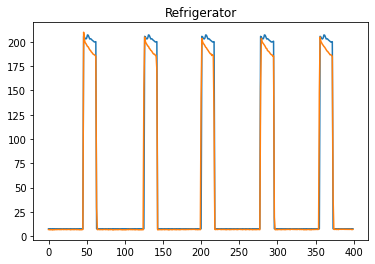

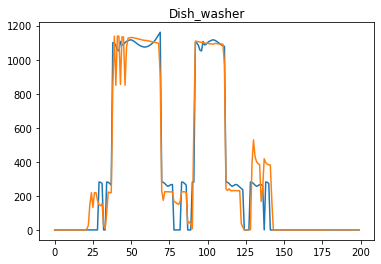

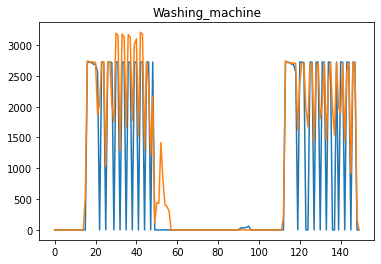

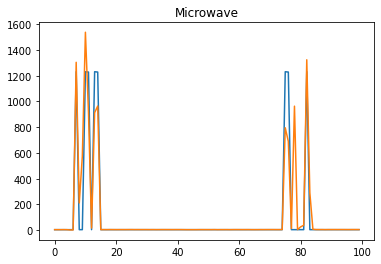

In [0]:
plotting_good_pred_segment(refg_pred, final_y, 500, 900, "Refrigerator")
plotting_good_pred_segment(dish_pred, final_y_dish1, 5450, 5650, "Dish_washer")
plotting_good_pred_segment(dryr_pred, final_y_dryr1, 5250, 5400, "Washing_machine")
plotting_good_pred_segment(micr_pred, final_y_micr, 6150, 6250, "Microwave")